### Введение

Для исследования предоставлена база с данными об учениках, которая содержит достаточно широкие сведения о молодых людях, их семейном положении, занятости и успеваемости по математике. Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

### Цель

В данном проекте целью является произвести предобработку набора данных и провести разведывательный анализ. Необходимо произвести их первичную оценку, подготовить данные для дальнейшего построения модели, которая предсказала бы результаты экзамена по математике для каждого ученика.

## Общий взгляд на набор данных

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
import numpy as np
from matplotlib.ticker import PercentFormatter
from collections import Counter
from pprint import pprint
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline
mpl.style.use('seaborn')

In [3]:
df = pd.read_csv('stud_math.xls')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В исходном файле содержатся данные для 396 учеников, предсталвенные 30 параметрами (17 номинативных и 13 числовых).

In [5]:
pd.set_option('display.max_columns',50)

In [6]:
display(df)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


Перед дальнейшим обзором каждого из имеющихся параметров создадим функции, повозволяющие унифицировать исследование данных.

In [7]:
def calculate_field_main_counts(df, str_field_name):
    """
    Функция возвращает кортеж, содержащий два числа: количество пустых элементов в столбце
    датафрейма и полное количество элементов в столбце
    """
    count_null = len(df[df[str_field_name].isnull()])
    count_total = len(df)
    return (count_null, count_total)

In [8]:
def field_info_nominative(df, str_field_name):
    """
    Данная функция позволяет производить анализ данных типа object в поле датафрейма.
    Оценить количество пустых значений, количество и вид уникальных значений, а также
    частотность для уникальных значений.
    Распределения представлены в виде столбчатых диаграм.
    Также частотность значений представлена в виде накопительной суммы, что позволяет определить
    те значения параметра, которые покрывают наибольший объем данных.
    """
    print("Поле: ", str_field_name)
#     total_count = len(df[str_field_name])
#     empty_count = len(df[str_field_name][df[str_field_name].isnull() == True])
    empty_count, total_count = calculate_field_main_counts(df, str_field_name)

    nan_count = len(df[str_field_name][df[str_field_name] == 'nan'])
    print("Количество пустых значений: {0} из {1} ({2:.2f}%)".format(
        empty_count, total_count, 100*empty_count/total_count))
    print("Количество пустых значений (nan): {0} из {1} ({2:.2f}%)".format(
        nan_count, total_count, 100*nan_count/total_count))
    print("Количество уникальных значений: ", df[str_field_name].nunique() - 1 if nan_count > 0 else 0)
    print(df[str_field_name].unique())
    data = df[str_field_name]
    fig, axs = plt.subplots(1, 3, figsize=(15,3))

    axs[0].set_title("Распределение количества значений\n признака " + str_field_name)
    axs[0].tick_params(labelrotation=45)
    hst = Counter(data)
    x = [tupl[0] for tupl in hst.most_common()]
    y = [tupl[1] for tupl in hst.most_common()]
    for i, y_i in enumerate(y):
        axs[0].text(i-0.05, 0.05*max(y), str(y_i), color='white', fontweight='bold', fontsize=15)
    axs[0].bar(x, y)

    axs[1].set_title("Распределение частот признака " + str_field_name)
    axs[1].tick_params(labelrotation=45)
    max_value = sum(hst.values())
    x = [tupl[0] for tupl in hst.most_common()]
    y = [tupl[1]/max_value for tupl in hst.most_common()]
    axs[1].bar(x, y)
    axs[1].yaxis.set_major_formatter(PercentFormatter(1))
    for i, y_i in enumerate(y):
        axs[1].text(i-0.05, 0.05*max(y), "{0:.0f}%".format(y_i*100), color='white', fontweight='bold', fontsize=15)

    axs[2].set_title("Частоты признака {}\n накопительной суммой".format(str_field_name))
    axs[2].tick_params(labelrotation=45)
    y2 = [sum(y[:i+1]) for i in range(len(y))]
    axs[2].yaxis.set_major_formatter(PercentFormatter(1))
    axs[2].bar(x, y2)
    for i, y_i in enumerate(y2):
        axs[2].text(i-0.05, 0.05*max(y), "{0:.0f}%".format(y_i*100), color='white', fontweight='bold', fontsize=15)


In [9]:
def replace_empty_nominative(df,str_field_name):
    """
    Для заданного столбца типа object в датафрейме пустые значения заменяются значениями None.
    """
    df[str_field_name] = df[str_field_name].astype(str).apply(lambda s: None if s.strip()=='' else s)

# Номинативные (строковые) переменные

### school - аббревиатура школы, в которой учится ученик

Поле:  school
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 0 из 395 (0.00%)
Количество уникальных значений:  0
['GP' 'MS']


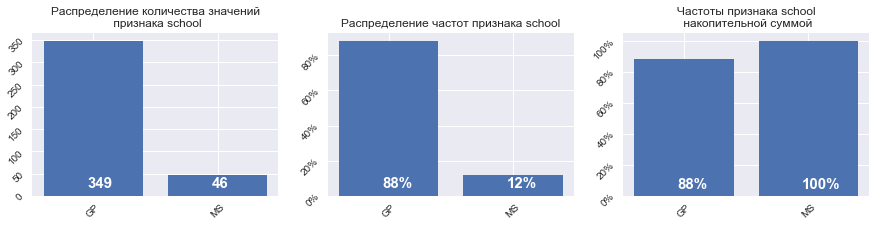

In [10]:
field_info_nominative(df,df.school.name)

 - количество пропущенных значений: НЕТ
 - уникальных информативных значений признака: 2, покривающих 100% данных
 - в данных **присутствует чрезвычайное смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен (больше 30) для проведения анализа данных.

**Слабый признак, скорее всего стоит исключить из исследования (подробнее см. в выводах)** 

### sex — пол ученика ('F' - женский, 'M' - мужской)

Поле:  sex
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 0 из 395 (0.00%)
Количество уникальных значений:  0
['F' 'M']


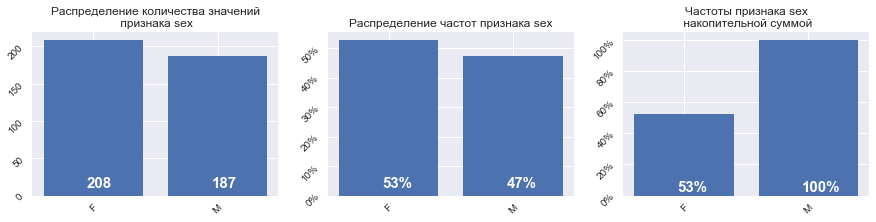

In [11]:
field_info_nominative(df, df.sex.name)

 - количество пропущенных значений: НЕТ
 - уникальных информативных значений признака: 2, покривающих 100% данных
 - оба из уникальных значений признака представлены в данных практически в равной степени


### address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [12]:
replace_empty_nominative(df, df.address.name)

Поле:  address
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 17 из 395 (4.30%)
Количество уникальных значений:  2
['U' 'nan' 'R']


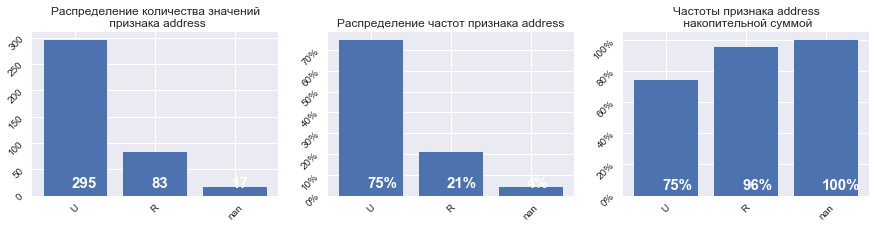

In [13]:
field_info_nominative(df, df.address.name)

 - количество пропущенных значений: низкое (меньше 5%)
 - уникальных информативных значений признака: 2, покривающих 96% данных
 - в данных **присутствуетс сильное смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен (больше 30) для проведения анализа данных.

**Удовлетворительный признак для анализа**

### famsize — размер семьи

In [14]:
replace_empty_nominative(df, df.famsize.name)

Поле:  famsize
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 27 из 395 (6.84%)
Количество уникальных значений:  2
['nan' 'GT3' 'LE3']


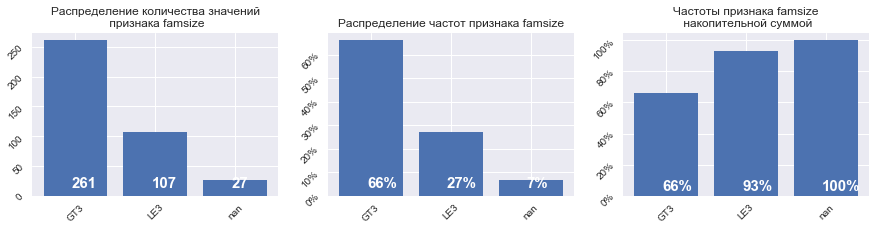

In [15]:

field_info_nominative(df, df.famsize.name)

 - количество пропущенных значений: приемлемое (5-10%)
 - уникальных информативных значений признака: 2, покривающих 93% данных
 - в данных **присутствует смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.

**Подходящий для анализа признак**

### Pstatus - статус совместного жилья родителей

In [16]:
replace_empty_nominative(df, df.Pstatus.name)

Поле:  Pstatus
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 45 из 395 (11.39%)
Количество уникальных значений:  2
['A' 'nan' 'T']


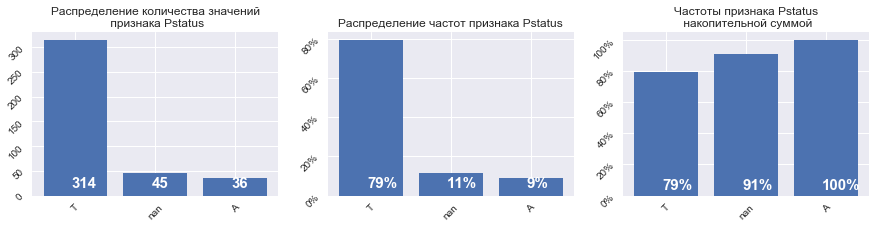

In [17]:
field_info_nominative(df, df.Pstatus.name)

 - количество пропущенных значений: высокое (больше 10%)
 - уникальных информативных значений признака: 2, покривающих 88% данных
 - в данных **присутствует чрезвычайное смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.

**Слабый признак, скорее всего, стоит исключить. К данному полю применимы те же оговорки, что и к полю school (будут уточнены в выводах)**

### Mjob - работа матери

In [18]:
replace_empty_nominative(df, df.Mjob.name)

Поле:  Mjob
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 19 из 395 (4.81%)
Количество уникальных значений:  5
['at_home' 'health' 'other' 'services' 'teacher' 'nan']


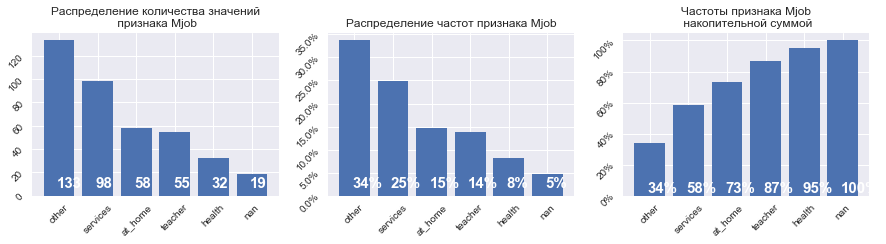

In [19]:
field_info_nominative(df, df.Mjob.name)

 - количество пропущенных значений: низкое (меньше 5%)
 - уникальных информативных значений признака: 4, однако покрывающих только 61% данных (исключая "nan" и "другое")
 - в данных **почти отсутствует смещение** в сторону одного из значений. 
 
 **Признак для анализа подходит**

### Fjob - работа отца

In [20]:
replace_empty_nominative(df, df.Fjob.name)

Поле:  Fjob
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 36 из 395 (9.11%)
Количество уникальных значений:  5
['teacher' 'other' 'nan' 'health' 'services' 'at_home']


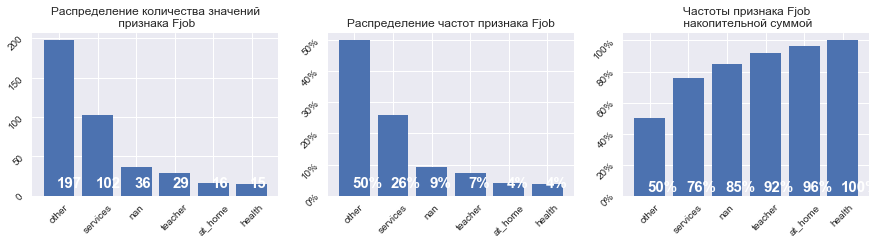

In [21]:
field_info_nominative(df, df.Fjob.name)

 - количество пропущенных значений: приемлемое (5-10%)
 - уникальных информативных значений признака: 4, покривающих 85% данных
 - в данных **присутствует сильное смещение** в сторону одного из значений, которое к тому же неинформативно ("другое"). Для некоторых из оставшихся уникальных значений размер выборки **недостаточен для проведения анализа данных.**

**Признак является слабым, скорее всего, лучше его исключить из анализа**

### reason - причина выбора школы

In [22]:
replace_empty_nominative(df, df.reason.name)

Поле:  reason
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 17 из 395 (4.30%)
Количество уникальных значений:  4
['course' 'other' 'home' 'reputation' 'nan']


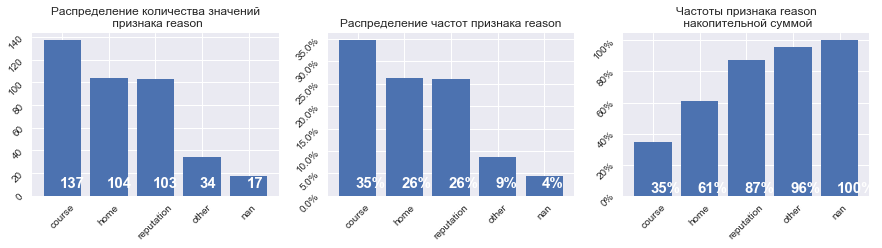

In [23]:
field_info_nominative(df, df.reason.name)

 - количество пропущенных значений: низкое (меньше 5%)
 - уникальных информативных значений признака: 3, покривающих 87% данных
 - в данных **почти отсутствует смещение** в сторону одного из значений.
 
**Уверенный признак для анализа.**

### guardian - опекун

Поле:  guardian
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 31 из 395 (7.85%)
Количество уникальных значений:  3
['mother' 'father' 'other' 'nan']


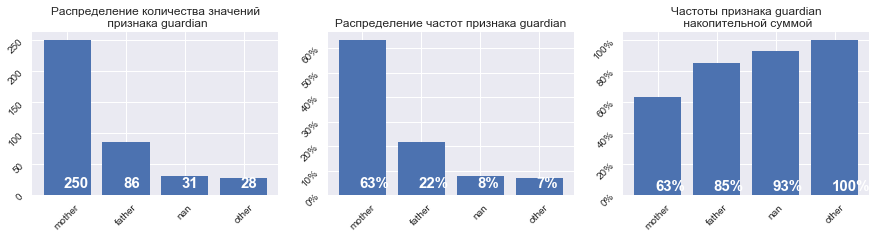

In [24]:
replace_empty_nominative(df, df.guardian.name)
field_info_nominative(df, df.guardian.name)

 - количество пропущенных значений: приемлемое (5-10%)
 - уникальных информативных значений признака: 2, покривающих 85% данных
 - в данных **присутствует смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.

### schoolsup — дополнительная образовательная поддержка

Поле:  schoolsup
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 9 из 395 (2.28%)
Количество уникальных значений:  2
['yes' 'no' 'nan']


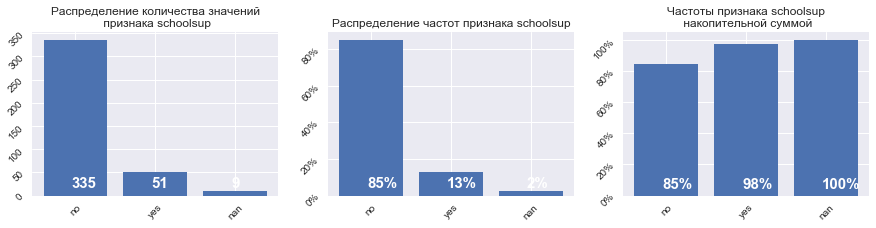

In [25]:
replace_empty_nominative(df, df.schoolsup.name)
field_info_nominative(df, df.schoolsup.name)

 - количество пропущенных значений: низкое (2%)
 - уникальных информативных значений признака: 2, покривающих 98% данных
 - в данных **присутствует сильное смещение** в сторону одного из значений. Размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.
 
 **Слабый признак для анализа**

### famsup — семейная образовательная поддержка

Поле:  famsup
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 39 из 395 (9.87%)
Количество уникальных значений:  2
['no' 'yes' 'nan']


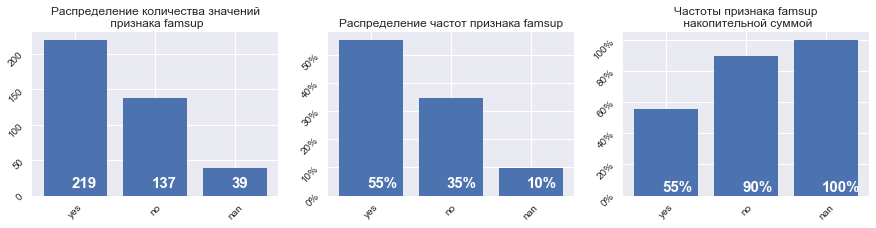

In [26]:
replace_empty_nominative(df, df.famsup.name)
field_info_nominative(df, df.famsup.name)

 - количество пропущенных значений: приемлемое (5-10%)
 - уникальных информативных значений признака: 2, покривающих 90% данных
 - в данных **присутствует слабое смещение** в сторону одного из значений. 

### paid — дополнительные платные занятия по математике

Поле:  paid
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 40 из 395 (10.13%)
Количество уникальных значений:  2
['no' 'nan' 'yes']


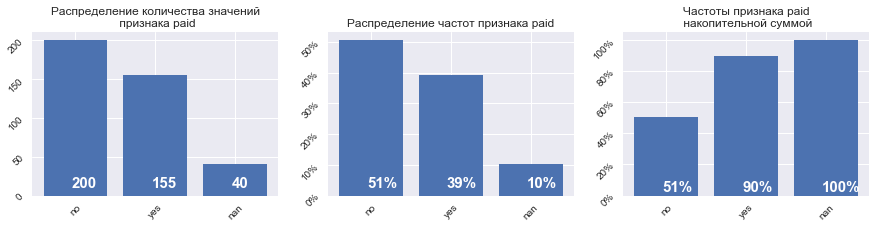

In [27]:
replace_empty_nominative(df, df.paid.name)
field_info_nominative(df, df.paid.name)

 - количество пропущенных значений: высокое (больше 10%)
 - уникальных информативных значений признака: 2, покривающих 90% данных
 - значения признака распределены почти с равными долями

### activities — дополнительные внеучебные занятия

Поле:  activities
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 14 из 395 (3.54%)
Количество уникальных значений:  2
['no' 'yes' 'nan']


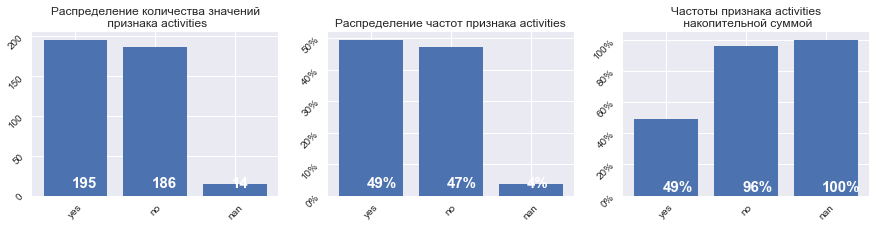

In [28]:
replace_empty_nominative(df, df.activities.name)
field_info_nominative(df, df.activities.name)

 - количество пропущенных значений: низкое (<5%)
 - уникальных информативных значений признака: 2, покривающих 96% данных
 - значения признака распределены равномерно

### nursery — посещал детский сад

Поле:  nursery
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 16 из 395 (4.05%)
Количество уникальных значений:  2
['yes' 'no' 'nan']


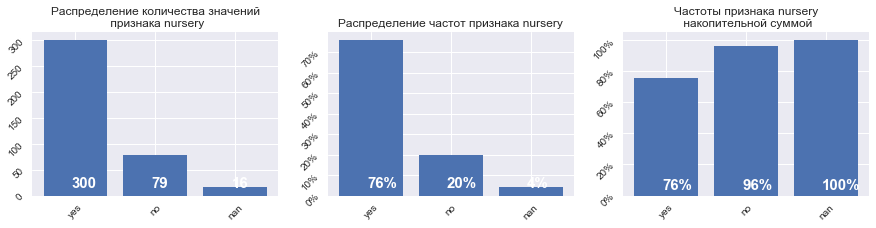

In [29]:
replace_empty_nominative(df, df.nursery.name)
field_info_nominative(df, df.nursery.name)

 - количество пропущенных значений: низкое (<5%)
 - уникальных информативных значений признака: 2, покривающих 96% данных
 - в данных **присутствует сильное смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.

### higher — хочет получить высшее образование

Поле:  higher
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 20 из 395 (5.06%)
Количество уникальных значений:  2
['yes' 'nan' 'no']


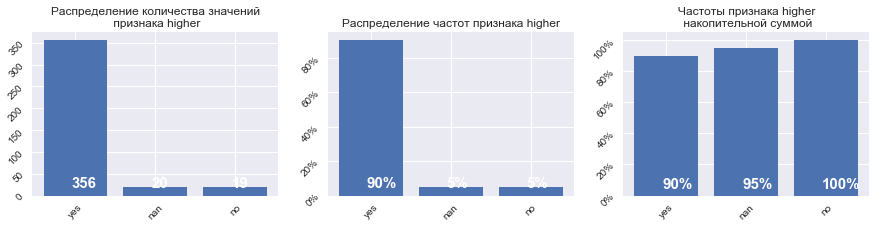

In [30]:
replace_empty_nominative(df, df.higher.name)
field_info_nominative(df, df.higher.name)

 - количество пропущенных значений: приемлемое  (5-10%)
 - уникальных информативных значений признака: 2, покривающих 95% данных
 - в данных **присутствует радикальное смещение** в сторону одного из значений. Размер выборки для меньшего из уникальных значений **недостаточен** для проведения анализа данных (<30%)
 
 **Данный признак следует исключить, неинформативен**

### internet — наличие интернета дома

Поле:  internet
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 34 из 395 (8.61%)
Количество уникальных значений:  2
['nan' 'yes' 'no']


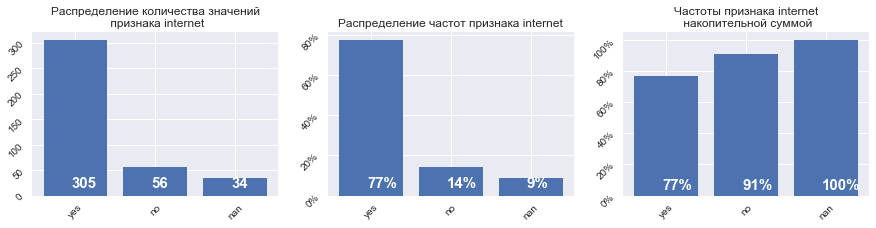

In [31]:
replace_empty_nominative(df, df.internet.name)
field_info_nominative(df, df.internet.name)

 - количество пропущенных значений: приемлемое  (5-10%)
 - уникальных информативных значений признака: 2, покривающих 91% данных
 - в данных **присутствует сильное смещение** в сторону одного из значений. Тем не менее, размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.
 
 **Слабый признак для анализа**

### romantic — в романтических отношениях

Поле:  romantic
Количество пустых значений: 0 из 395 (0.00%)
Количество пустых значений (nan): 31 из 395 (7.85%)
Количество уникальных значений:  2
['no' 'nan' 'yes']


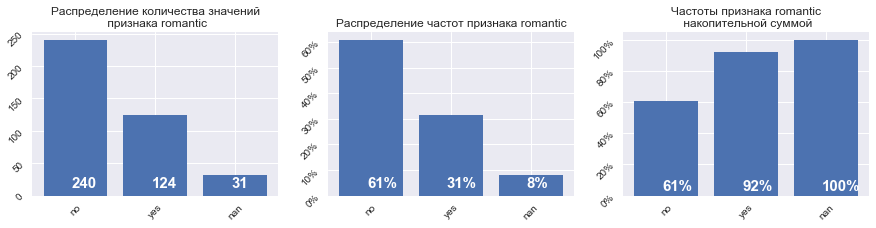

In [32]:
replace_empty_nominative(df, df.romantic.name)
field_info_nominative(df, df.romantic.name)

 - количество пропущенных значений: приемлемое (5-10%)
 - уникальных информативных значений признака: 2, покривающих 92% данных
 - в данных **присутствует смещение** в сторону одного из значений. Размер выборки для меньшего из уникальных значений достаточен для проведения анализа данных.
 
 **Надежный признак для анализа**

# Числовые переменные

In [33]:
sns.set()

Определим функции для работы с числовыми столбцами набора данных

In [34]:
def calculate_outlier_params(df, str_field_name):
    """
    Данная функция определяет левую и правую границы диапазона для определения выбросав 
    в заданном столбце датафрейма.
    Проверка на тип данных в столбце не предусмотрена.
    """
    perc25 = df[str_field_name].quantile(0.25)
    perc75 = df[str_field_name].quantile(0.75)
    IQR = perc75 - perc25
    left_border = perc25 - 1.5*IQR
    right_border = perc75 + 1.5*IQR
    return (left_border, right_border)    

In [35]:
def field_info_numeric(df, str_field_name, bins=10):
    """
    Функция выводит основные аналитические характеристики для заданного числового столбца датафрейма.
    """
    print("Поле: ", str_field_name)
    count_null, count_total = calculate_field_main_counts(df, str_field_name)
    print("Количество пустых значений: {0} из {1} ({2:.2f}%)".format(count_null, count_total, 100*count_null/count_total))
    count_unique = df[str_field_name].nunique()
    print("Количество уникальных значений: ", count_unique)
    if count_unique < 10:
        print("(value,rate) = ",[tple for tple in Counter(df[str_field_name]).most_common() if not np.isnan(tple[0])])
    print(df[str_field_name].describe())
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    sns.distplot(df[str_field_name], ax=axs[0], bins=bins).set_title('Распределение признака  '+str_field_name)
    sns.boxplot(x=str_field_name, data=df, ax=axs[1]).set_title("Боксплот для признака " + str_field_name)
    
    left_border, right_border = calculate_outlier_params(df, str_field_name)
    print("Границы выбросов: [{A},{B}]".format(A=left_border, B=right_border))
    outliers_count = len(df[df[str_field_name] < left_border]) + len(df[df[str_field_name] > right_border])
    print("Количество выбросов: {0} ({1:.2f}%)".format(outliers_count,100*outliers_count/count_total))
    
    pass

In [36]:
def process_numeric_nulls(df, str_field_name, param, mode='process_value'):
    """
    Функция заменяет для заданного столбца датафрема нулевые значения значением, переданном
    через param.
    
    Пока эта функция не срабатывает почему-то как нужно, поэтому находится в тестовом режиме.
    """
    if mode == 'process_value':
        return
        #недостижимый код. Должен бы был отрабатывать нормально, но записывает данные не туда. Пока отладить
        #ошибку не удалось
        df[str_field_name] = pd.Series(np.array([param if np.isnan(x) else x  for x in df[str_field_name]]))

In [37]:
def process_numeric_outliers(df, str_field_name, param, mode='replace_value'):
    """
    Функция обрабатывает выбросы для заданного числового столбца датафрейма.
    Есть несколько режимов обработки выбросов:
    mode == 'replace_value': - заменяет значение выбросов значением, переданным через param
    if mode == 'delete_over_param' и if mode == 'delete_less_param': через param задается граница
        значения для определеня выброса. Записи, значеие заданной колонки в котором больше или меньше
        (соответственно) заданной границы, удаляются.
    """
    if mode == 'replace_value':
        return
        #недостижимый код. Должен бы был отрабатывать нормально, но записывает данные не туда. Пока отладить
        #ошибку не удалось
        left_border, right_border = calculate_outlier_params(df, str_field_name)
        df[df[str_field_name] < left_border] = param
        df[df[str_field_name] > right_border] = param
    if mode == 'delete_over_param':
        # здесь почему-то не срабатывает, не удаляет из датафрейма. Как будто 
        # надо бы ref-параметр прописать
        df = df.drop(df[df[str_field_name] > param].index)
    if mode == 'delete_less_param':
        df = df.drop(df[df[str_field_name] < param].index)

Числовые признаки будем оценивать по следующей схеме:
1. количество пропущенных значений: низкое (<5%), умеренное (5-10%), высокое (>10%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак, больше и много больше 20 - непрерывный признак
    - если количество пропущенных значений низкое и умеренное и признак является дискретным - то можно пропущенные значения заменить медианой или модой
3. Количество выбросов: есть или нет.
    - если выбросы не сильно отличаются от границ диапазона определения границ выбросов, то можно их приравнять к этим границам. Если сильно - заменить на null и в дальнейшем исключить такие записи

### age — возраст ученика

Поле:  age
Количество пустых значений: 0 из 395 (0.00%)
Количество уникальных значений:  8
(value,rate) =  [(16, 104), (17, 98), (18, 82), (15, 82), (19, 24), (20, 3), (22, 1), (21, 1)]
count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
Границы выбросов: [13.0,21.0]
Количество выбросов: 1 (0.25%)


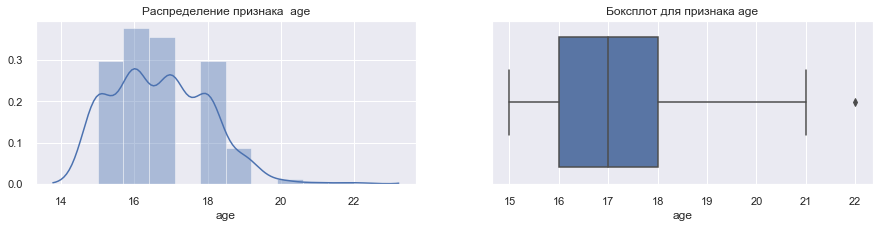

In [38]:
field_info_numeric(df, df.age.name)

1. количество пропущенных значений: НЕТ
2. количество уникальных значений: низкое (<10-20) - дискретный признак 
3. Количество выбросов: есть выброс (формально), но по факту выбросом не является


### Medu — образование матери

Поле:  Medu
Количество пустых значений: 3 из 395 (0.76%)
Количество уникальных значений:  5
(value,rate) =  [(4.0, 131), (2.0, 102), (3.0, 97), (1.0, 59), (0.0, 3)]
count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64
Границы выбросов: [-1.0,7.0]
Количество выбросов: 0 (0.00%)


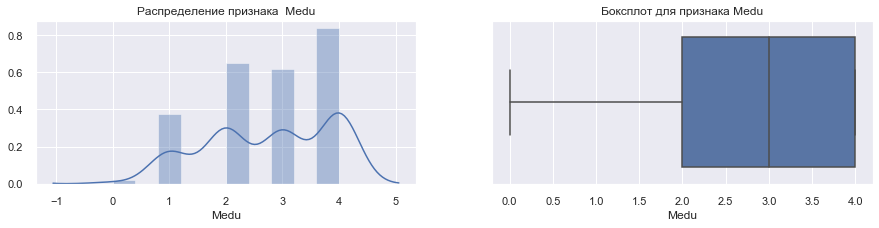

In [39]:
field_info_numeric(df, df.Medu.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - заменяем пропущенные значения модой (значенеием 4)
3. Количество выбросов: НЕТ


In [40]:
process_numeric_nulls(df, df.Medu.name, param=4)

### Fedu — образование отца

Поле:  Fedu
Количество пустых значений: 24 из 395 (6.08%)
Количество уникальных значений:  6
(value,rate) =  [(2.0, 106), (3.0, 96), (4.0, 88), (1.0, 78), (0.0, 2), (40.0, 1)]
count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64
Границы выбросов: [0.5,4.5]
Количество выбросов: 3 (0.76%)


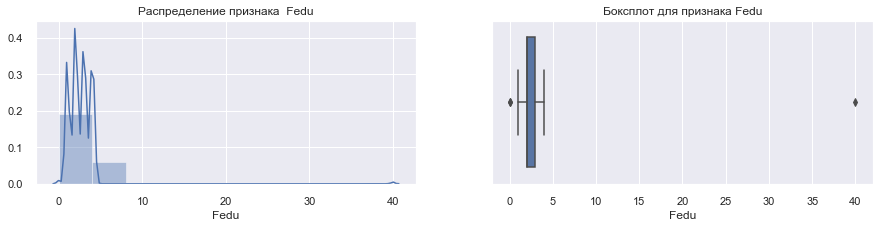

In [41]:
field_info_numeric(df, df.Fedu.name)

1. количество пропущенных значений: умеренное (5-10%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные значения заменяем медианой (3)
3. Количество выбросов: есть или нет.
    - выбросы заменяем модой (2)

In [42]:
process_numeric_nulls(df, df.Fedu.name, param=3)
process_numeric_outliers(df, df.Fedu.name, param=2)

### traveltime — время в пути до школы

Поле:  traveltime
Количество пустых значений: 28 из 395 (7.09%)
Количество уникальных значений:  4
(value,rate) =  [(1.0, 242), (2.0, 96), (3.0, 22), (4.0, 7)]
count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64
Границы выбросов: [-0.5,3.5]
Количество выбросов: 7 (1.77%)


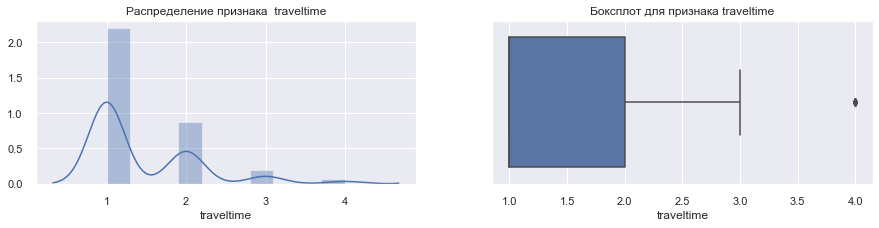

In [43]:
field_info_numeric(df, df.traveltime.name)

1. количество пропущенных значений: умеренное (5-10%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные значения заменяем модой = медиане = 1
3. Количество выбросов: есть (фактически), но на самом деле это приемлемое значение признака

In [44]:
process_numeric_nulls(df, df.traveltime.name, param=1)

### studytime — время на учёбу помимо школы в неделю

Поле:  studytime
Количество пустых значений: 7 из 395 (1.77%)
Количество уникальных значений:  4
(value,rate) =  [(2.0, 194), (1.0, 103), (3.0, 64), (4.0, 27)]
count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64
Границы выбросов: [-0.5,3.5]
Количество выбросов: 27 (6.84%)


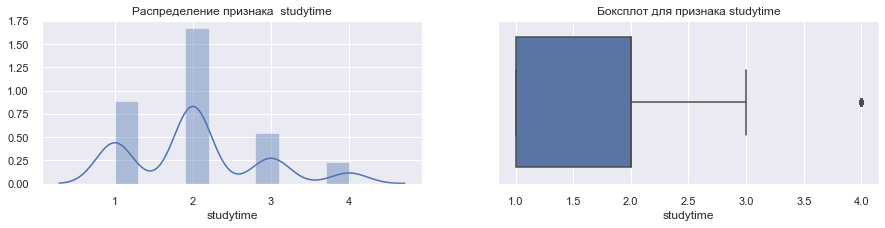

In [45]:
field_info_numeric(df, df.studytime.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные значения заменяем на 2
3. Количество выбросов: НЕТ

In [103]:
process_numeric_nulls(df, df.studytime.name, 2)

### failures — количество внеучебных неудач

Поле:  failures
Количество пустых значений: 22 из 393 (5.60%)
Количество уникальных значений:  4
(value,rate) =  [(0.0, 292), (1.0, 49), (3.0, 15), (2.0, 15)]
count    371.000000
mean       0.334232
std        0.739896
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

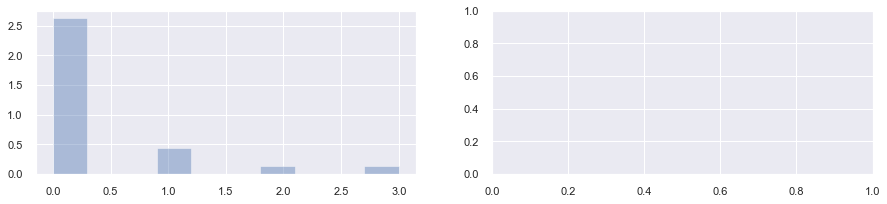

In [104]:
field_info_numeric(df, df.failures.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные значения заменяем на 0
3. Количество выбросов: есть и по факту это допустимое значение (3 - по количеству неудач) или видимо ошибка ввода (4), которую стоит заменить на 3
    - выбросы заменяем значением 3

Стал выводить здесь ошибку. Функция типовая, должно все сработать нормально. Выводы остались с тех пор, когда ошибка еще не возникала. 

In [48]:
process_numeric_nulls(df, df.failures.name, 0)
process_numeric_outliers(df, df.failures.name, 3)

### famrel — семейные отношения

Поле:  famrel
Количество пустых значений: 27 из 395 (6.84%)
Количество уникальных значений:  6
(value,rate) =  [(4.0, 182), (5.0, 99), (3.0, 62), (2.0, 17), (1.0, 7), (-1.0, 1)]
count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64
Границы выбросов: [2.5,6.5]
Количество выбросов: 25 (6.33%)


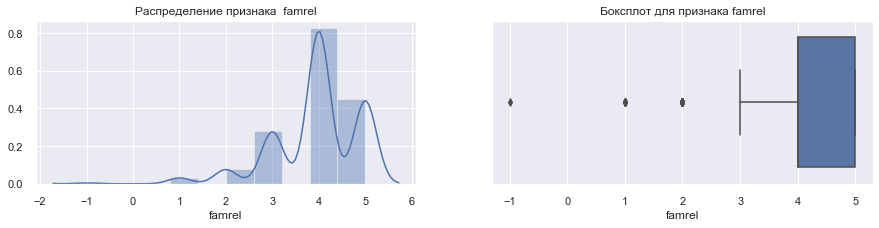

In [49]:
field_info_numeric(df, df.famrel.name)

1. количество пропущенных значений: умеренное (5-10%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные значения заменяем на 4 (мода = медиана)
3. Количество выбросов: ЕСТЬ, скорее всего ошибка внесения, можно заменить на 1

In [50]:
process_numeric_nulls(df, df.famrel.name, 4)
process_numeric_outliers(df, df.famrel.name, 1)

### freetime — свободное время после школы

Поле:  freetime
Количество пустых значений: 11 из 395 (2.78%)
Количество уникальных значений:  5
(value,rate) =  [(3.0, 153), (4.0, 112), (2.0, 63), (5.0, 38), (1.0, 18)]
count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64
Границы выбросов: [1.5,5.5]
Количество выбросов: 18 (4.56%)


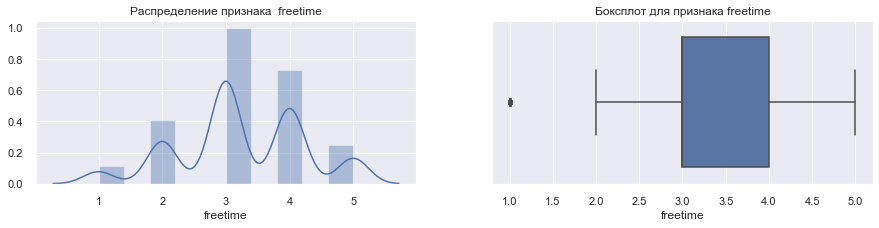

In [51]:
field_info_numeric(df, df.freetime.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - пропущенные заменяем на 3
3. Количество выбросов: НЕТ

In [53]:
process_numeric_nulls(df, df.freetime.name, 3)

### goout — проведение времени с друзьями

Поле:  goout
Количество пустых значений: 8 из 395 (2.03%)
Количество уникальных значений:  5
(value,rate) =  [(3.0, 127), (2.0, 101), (4.0, 84), (5.0, 52), (1.0, 23)]
count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64
Границы выбросов: [-1.0,7.0]
Количество выбросов: 0 (0.00%)


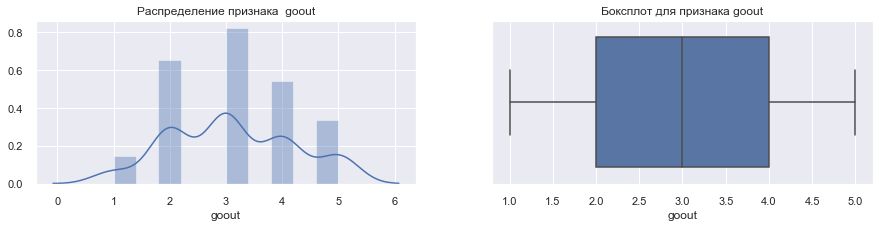

In [54]:
field_info_numeric(df, df.goout.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - заменяем пропущенные на 3
3. Количество выбросов: НЕТ

In [55]:
process_numeric_nulls(df, df.goout.name, 3)

### health — текущее состояние здоровья

Поле:  health
Количество пустых значений: 15 из 395 (3.80%)
Количество уникальных значений:  5
(value,rate) =  [(5.0, 138), (3.0, 89), (4.0, 63), (1.0, 47), (2.0, 43)]
count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64
Границы выбросов: [0.0,8.0]
Количество выбросов: 0 (0.00%)


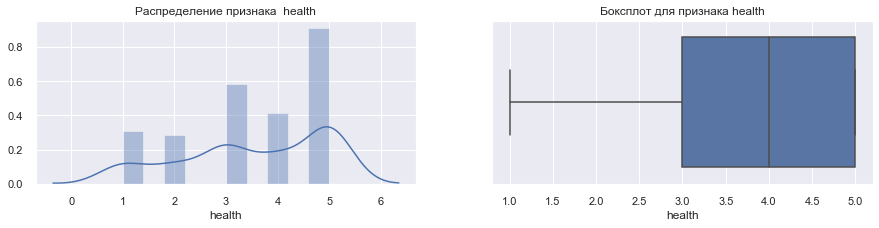

In [56]:
field_info_numeric(df, df.health.name)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: низкое (<10-20) - дискретный признак
    - заменяем пропущенные на 3
3. Количество выбросов: НЕТ

In [57]:
process_numeric_nulls(df, df.health.name, 3)

### absences — количество пропущенных занятий

Поле:  absences
Количество пустых значений: 12 из 395 (3.04%)
Количество уникальных значений:  36
count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64
Границы выбросов: [-12.0,20.0]
Количество выбросов: 17 (4.30%)


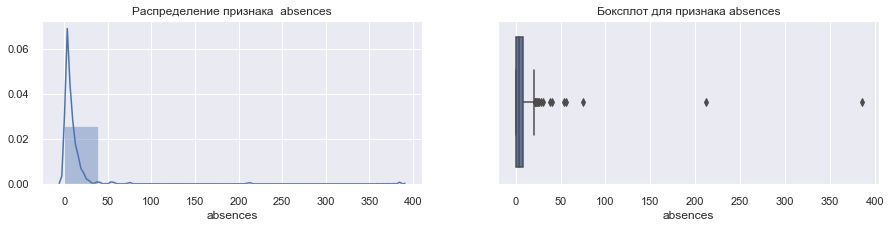

In [58]:
field_info_numeric(df, df.absences.name)

Числовые признаки будем оценивать по следующей схеме:
1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: больше и много больше 20 - непрерывный признак
    - пропущенные значения заменяем на 4 (между средним и медианой)
3. Количество выбросов: ЕСТЬ
    - Наконец-то попался действительно числовой непрерывный признак. Большинство выбросов (те, которые до 100) можно считать действительно настоящими значениями. Однако значения больше 100 - скорее всего либо ошибка внесения, либо человек вообще не появлялся на занятиях и такие записи следует исключить: исключаем выбросы со значением больше 100|

In [59]:
process_numeric_outliers(df, df.absences.name, param=100, mode='delete_over_param')
df = df.drop(df[df.absences > 100].index) #потому что не срабатывает удаление через функцию выше. Надо будет исправить
process_numeric_nulls(df, df.absences.name, 4)

### score — баллы по госэкзамену по математике

Поле:  score
Количество пустых значений: 6 из 393 (1.53%)
Количество уникальных значений:  18
count    387.000000
mean      52.196382
std       22.914748
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64
Границы выбросов: [-5.0,115.0]
Количество выбросов: 0 (0.00%)


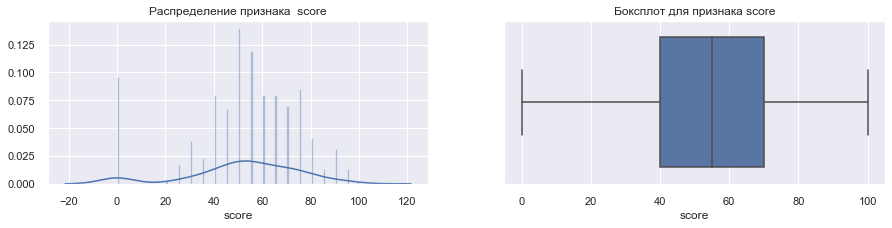

In [60]:
field_info_numeric(df, df.score.name, bins=100)

1. количество пропущенных значений: низкое (<5%)
2. количество уникальных значений: больше и много больше 20 - непрерывный признак (ну и по смыслу понятно, что это не категорийный признак)
    - пропущенные значения заменяем на 50
3. Количество выбросов: НЕТ

In [61]:
process_numeric_nulls(df, df.score.name, param=50)

Обработка значений результата экзамена, равных 0. Скорее всего, результат, равный 0, может расцениваться как признак, был ли вообще сдан экзамен (подробности в выводах). Добавим новый признак в набор данных.

In [62]:
df['exam_confirmed'] = pd.Series(np.array(['YES' if value>0 else 'NO' for value in df.score ]), index=df.index)

Поле:  exam_confirmed
Количество пустых значений: 0 из 393 (0.00%)
Количество пустых значений (nan): 0 из 393 (0.00%)
Количество уникальных значений:  0
['YES' 'NO']


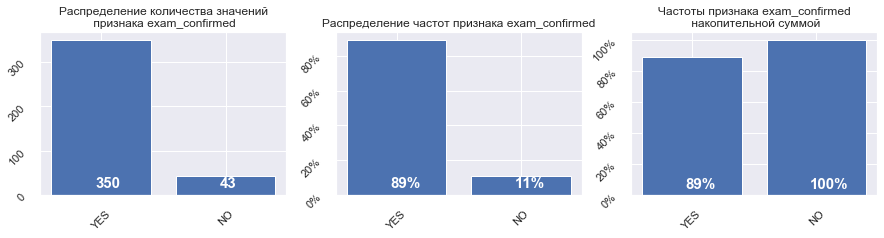

In [63]:
field_info_nominative(df, df.exam_confirmed.name)

### studytime, granular

Поле:  studytime, granular
Количество пустых значений: 7 из 393 (1.78%)
Количество уникальных значений:  4
(value,rate) =  [(-6.0, 192), (-3.0, 103), (-9.0, 64), (-12.0, 27)]
count    386.000000
mean      -6.116580
std        2.532774
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64
Границы выбросов: [-10.5,1.5]
Количество выбросов: 27 (6.87%)


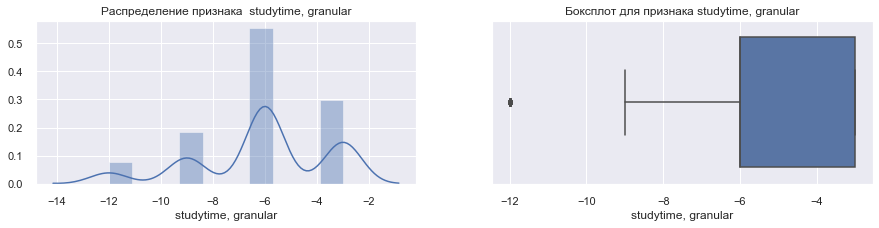

In [64]:
field_info_numeric(df, 'studytime, granular')

Весьма странный признак, по названию должен отражать время на учебу помимо школы, но при этом больше половины значений (медиана -3) имеют отрицательное значение. Данный признак следует удалить.

In [65]:
df.drop(['studytime, granular'], axis=1, inplace=True)

# Выводы по анализу значений в столбцах

### Номинативные признаки

Большинство номинативных признаков удовлетворительные и подходят для анализа, содержат мало пропущенных значений (пропущенные значения можно заменить наиболее частными значениями, как это сделано для числовых признаков, а можно исключать во время анализа, написав соответствующую функцию в дальнейшем), количество уникальных значений достаточно и данные распределены без значительных смещений.

Поля **"school" и "schoolsup" скорее не следует рассматривать в анализе** или же следует формулировать выводы только для одного уникального значения данных признаков. Рассмотрим на примере признака Школа:
1. так как размер выборок учеников из разных школ значительно отличается, нужно относиться внимательнее к данным о сравнении этих двух школ (хотя размер выборки для школы MS формальному условию >30 удовлетворяет). То есть данные для одной из школ представлены значительно большим количеством, поэтому данным относительно другой школы мы можем доверять значительно меньше, поэтому
2. возможно, полученные результаты лучше не сравнивать друг с другом, а обозначать как результаты для каждой из двух конкретных школ по отдельности
Похожая ситуация и для признака "schoolsup" - дополнительная поддержка в большинстве случае или отсутствует или нет данных. Поэтому делать вывод о ее влиянии следует осторожно или же вообще исключить из рассмотрения.

Также следует **исключить из рассмотрения признаки Pstatus, Fjob, higher**. Эти признаки теряют свою информативность по причине очень сильного смещения данных к одному из уникальных значений признака, при этом для альтернативного значения может даже быть недостаточно данных в выборке (как для признака higher). 
Или же для признака Fjob данные смещены в сторону значения "другое", что является малоинформативным.

### Числовые признаки

Большинство числовых признаков являются по сути своей также категориальными, с небольшим количеством значений, которые могут быть заменены описанием группы, к которой относятся значение данного признака. Для этих признаков были проведены следующие работы:
- пропущеные значения были заменены на наиболее частотные
- обработаны выбросы (удалены или заменены допустимыми занчениями)

Также в данных имеются два **непрерывных числовых признака - absences и score**. Для данных признаков были обработаны пропущенные значения и выбросы. Также на основе количества набранных баллов на экзамене был **введен дополнительный номинативный признак - exam_confirmed** - сдавал ли вообще экзамен данный ученик.

# Корреляционный анализ

Так как параметры **traveltime, studytime, failures** являются по сути хоть и числовыми, но число - это лишь номер категории, номер группы, при этом значения внутри групп не соотносятся друг с другом, поэтому в анализе корреляций эти параметры не имеют смысла.

Параметры **Medu и Fedu** имеют внутри числовых значений имеют одинаковые условия попадания в эту группу, поэтому для них корреляция может иметь смысл. Хотя лучше все-таки использовать методы для оценки кластеризации, но пока это за пределами данного исследования.

In [67]:
df[[df.Medu.name, df.Fedu.name]].corr()

,Medu,Fedu
Medu,1.000000,0.275778
Fedu,0.275778,1.000000


можно испльзовать оба параметра, сильной корреляции между ними нет.

Параметры **famrel, freetime, goout, health** можно рассматривать совместно на предмет корреляций. Данные параметры имеют соотносимые значения (в одних единицах измерения и в одном масштабе - оценка).

In [74]:
df[[df.famrel.name, df.freetime.name, df.goout.name, df.health.name]].corr()

,famrel,freetime,goout,health
famrel,1.000000,0.170845,0.068511,0.074817
freetime,0.170845,1.000000,0.294446,0.059978
goout,0.068511,0.294446,1.000000,-0.018411
health,0.074817,0.059978,-0.018411,1.000000


Нельзя выделить какую-то пару коррелируемых параметров, которые при анализе бы дублировали друг друга.

In [75]:
df[[df.absences.name, df.score.name]].corr()

,absences,score
absences,1.000000,0.031698
score,0.031698,1.000000


Ожидаемой была бы отрицательная корреляция между колчеством пропущенных занятий (чем больше) и баллом на экзамене (тем меньше). Однако корреляция оказалось не такой. Тем интереснее будет анализ.

## Анализ номинативных значений

In [76]:
def nominative_score_boxplots(df, str_field_name):
    fig, ax = plt.subplots(figsize=(15,3))
    sns.boxplot(x=str_field_name, y=df.score.name,
#                data=df.loc[df.loc[:,str_field_name].isin(df.loc[:,str_field_name].value_counts().index[:10])],
               data=df, #.loc[df[str_field_name]].isin(df[str_field_name].unique()),
               ax=ax)
    plt.show()

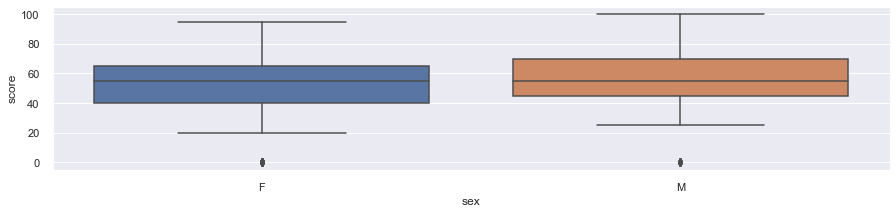

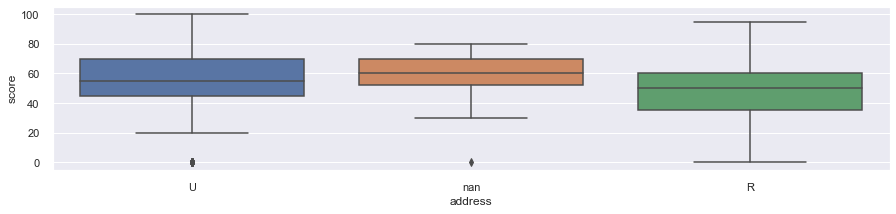

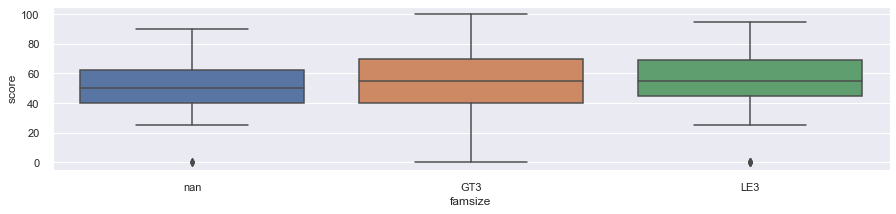

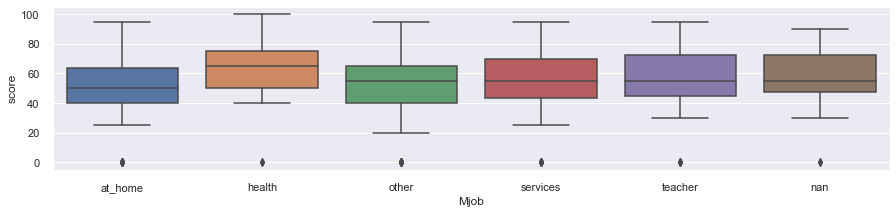

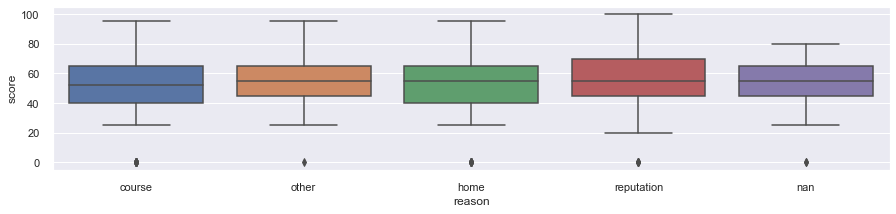

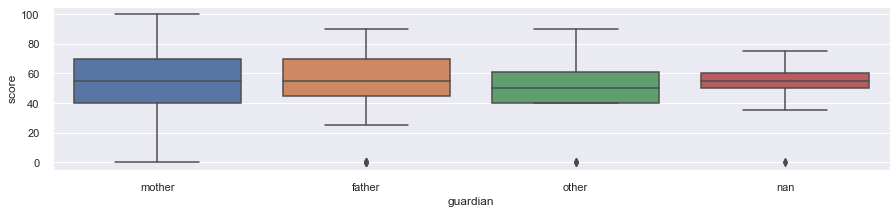

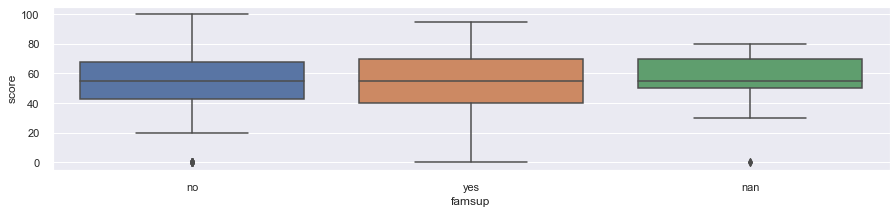

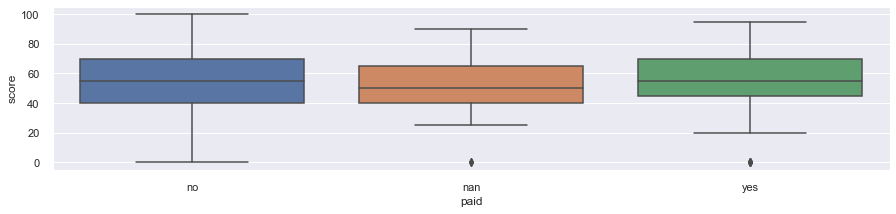

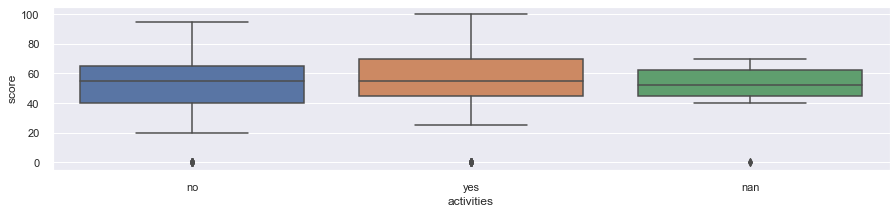

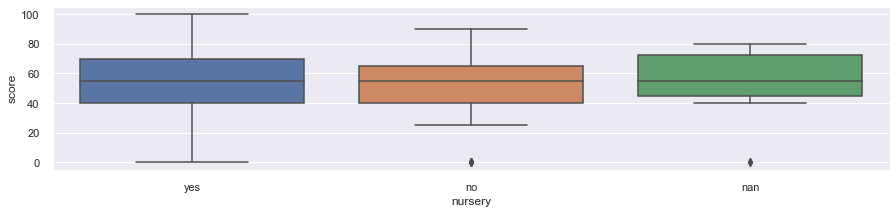

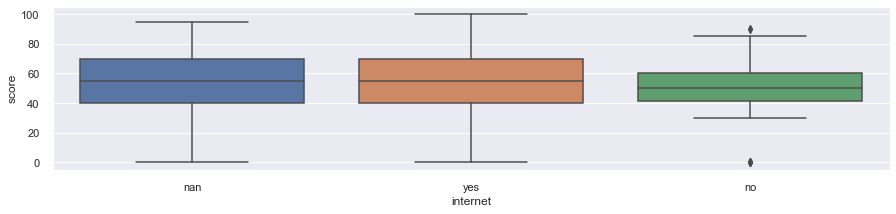

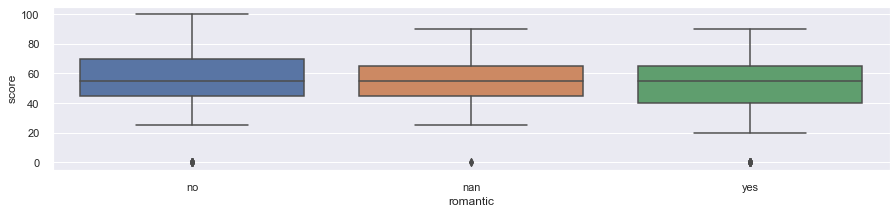

In [79]:
for str_field_name in [df.sex.name, df.address.name, df.famsize.name, df.Mjob.name, df.reason.name, 
                      df.guardian.name, df.famsup.name, df.paid.name, df.activities.name, df.nursery.name,
                      df.internet.name, df.romantic.name]:
    nominative_score_boxplots(df, str_field_name)

Для всех признаков видно, что они могут влиять на результат экзамена. Нет случая, когда количество баллов распределено независимо от значения признака.

In [101]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [102]:
for str_field_name in [df.sex.name, df.address.name, df.famsize.name, df.Mjob.name, df.reason.name, 
                      df.guardian.name, df.famsup.name, df.paid.name, df.activities.name, df.nursery.name,
                      df.internet.name, df.romantic.name]:
    get_stat_dif(str_field_name)

# Итоги

Данные содержали приемлемое количество пропущенных значений и выбросов, которые в большинстве случае можно заменить наиболее частотными значениями.

Среди признаков не наблюдается сильно коррелирующих пар, поэтому исключать по этой причине признаки нет необходимости.

Некоторые признаки могут быть исключены из анализа из-за своей сильной смещенности к одному из значений или из-за недостаточной информативности (Pstatus, Fjob, higher и внимательно относиться к "school" и "schoolsup")

Также можно на основе 0 значений признака score выделить дополнительный категорийный признак (прошел ли вообще экзамен для ученика)